In [16]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch

In [9]:
path = "/ssd_scratch/cvit/anirudhkaushik/ADNI1:Complete 3Yr 3T/ADNI/002_S_0413/MPR____N3__Scaled/2006-05-19_16_17_47.0/I40657/ADNI_002_S_0413_MR_MPR____N3__Scaled_Br_20070216232854688_S14782_I40657.nii"
img = nib.load(path)


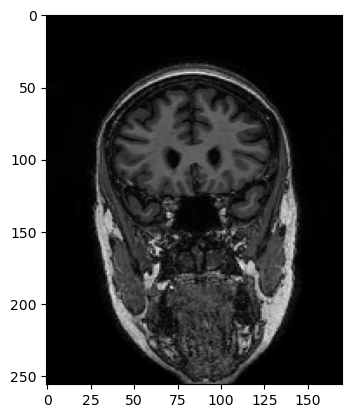

In [14]:
# adjust so that axial view isnt squashed
# get axial aspect ratio
aspect = img.header.get_zooms()
aspect = aspect[0]/aspect[2]

a1 = plt.subplot(1,1,1)
plt.imshow(img.get_fdata()[:,100,:], cmap='gray')
a1.set_aspect(aspect) 
plt.show()


In [17]:
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=32, pretrained=True)

/home2/anirudhkaushik/miniconda3/envs/pytorch/lib/python3.10/site-packages/torch/hub.py:294: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/mateuszbuda/brain-segmentation-pytorch/zipball/master" to /home2/anirudhkaushik/.cache/torch/hub/master.zip
Downloading: "https://github.com/mateuszbuda/brain-segmentation-pytorch/releases/download/v1.0/unet-e012d006.pt" to /home2/anirudhkaushik/.cache/torch/hub/checkpoints/unet-e012d0

In [61]:
from torchvision import transforms

preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=0, std=1),
])

class Dataset(torch.utils.data.Dataset):
    def __init__(self, paths):
        self.paths = paths

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = nib.load(self.paths[idx])
        img = img.get_fdata()[:, 100, :]
        img = cv2.resize(img, (256, 256))
        img = img/img.max()
        img = (img * 255).astype(np.uint8)
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        # convert to byte
        img = preprocess(img)
        return img
    
dataset = Dataset([path])
loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)


(256, 256)


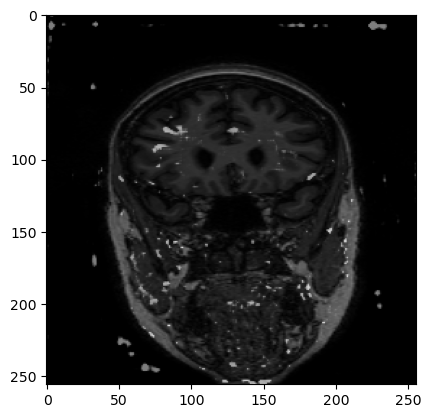

In [68]:
for img in loader:
    pred = model(img)
    pred = pred[0, 0].detach().numpy()
    print(pred.shape)
    # show as a segmentation mask on top of the original image
    plt.imshow(img[0].permute(1,2,0).detach().numpy())
    plt.imshow(pred, cmap='gray', alpha=0.5)

    plt.show()
    break
